In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pydot
import collections
import graphviz
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.tree import export_graphviz
from graphviz import Source

In [70]:
data = pd.read_csv("slump_test.csv")

In [71]:
data.head()

,No,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,1,273.0,82.0,105.0,210.0,9.0,904.0,680.0,23.0,62.0,34.99
1,2,163.0,149.0,191.0,180.0,12.0,843.0,746.0,0.0,20.0,41.14
2,3,162.0,148.0,191.0,179.0,16.0,840.0,743.0,1.0,20.0,41.81
3,4,162.0,148.0,190.0,179.0,19.0,838.0,741.0,3.0,21.5,42.08
4,5,154.0,112.0,144.0,220.0,10.0,923.0,658.0,20.0,64.0,26.82


# Index 
1. [EDA](#EDA)
2. [Feature Selection](#Feature Selection)
3. [Modeling](#Modeling)
      
      a.[Decision Tree](#Decision Tree)
      
      b.[Random Forest](#Random Forest)
4. [Future Work](#Future work)

### EDA

###### First of all, we want to check NA values 

In [72]:
np.sum(data.isnull()) #There are no NAs 

No                                    0
Cement                                0
Slag                                  0
Fly ash                               0
Water                                 0
SP                                    0
Coarse Aggr.                          0
Fine Aggr.                            0
SLUMP(cm)                             0
FLOW(cm)                              0
Compressive Strength (28-day)(Mpa)    0
dtype: int64

###### Then we want to see the description of the data 

In [73]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 11 columns):
No                                    103 non-null int64
Cement                                103 non-null float64
Slag                                  103 non-null float64
Fly ash                               103 non-null float64
Water                                 103 non-null float64
SP                                    103 non-null float64
Coarse Aggr.                          103 non-null float64
Fine Aggr.                            103 non-null float64
SLUMP(cm)                             103 non-null float64
FLOW(cm)                              103 non-null float64
Compressive Strength (28-day)(Mpa)    103 non-null float64
dtypes: float64(10), int64(1)
memory usage: 8.9 KB


All the variables are quantitative

###### What's the distribution of those vsriables?

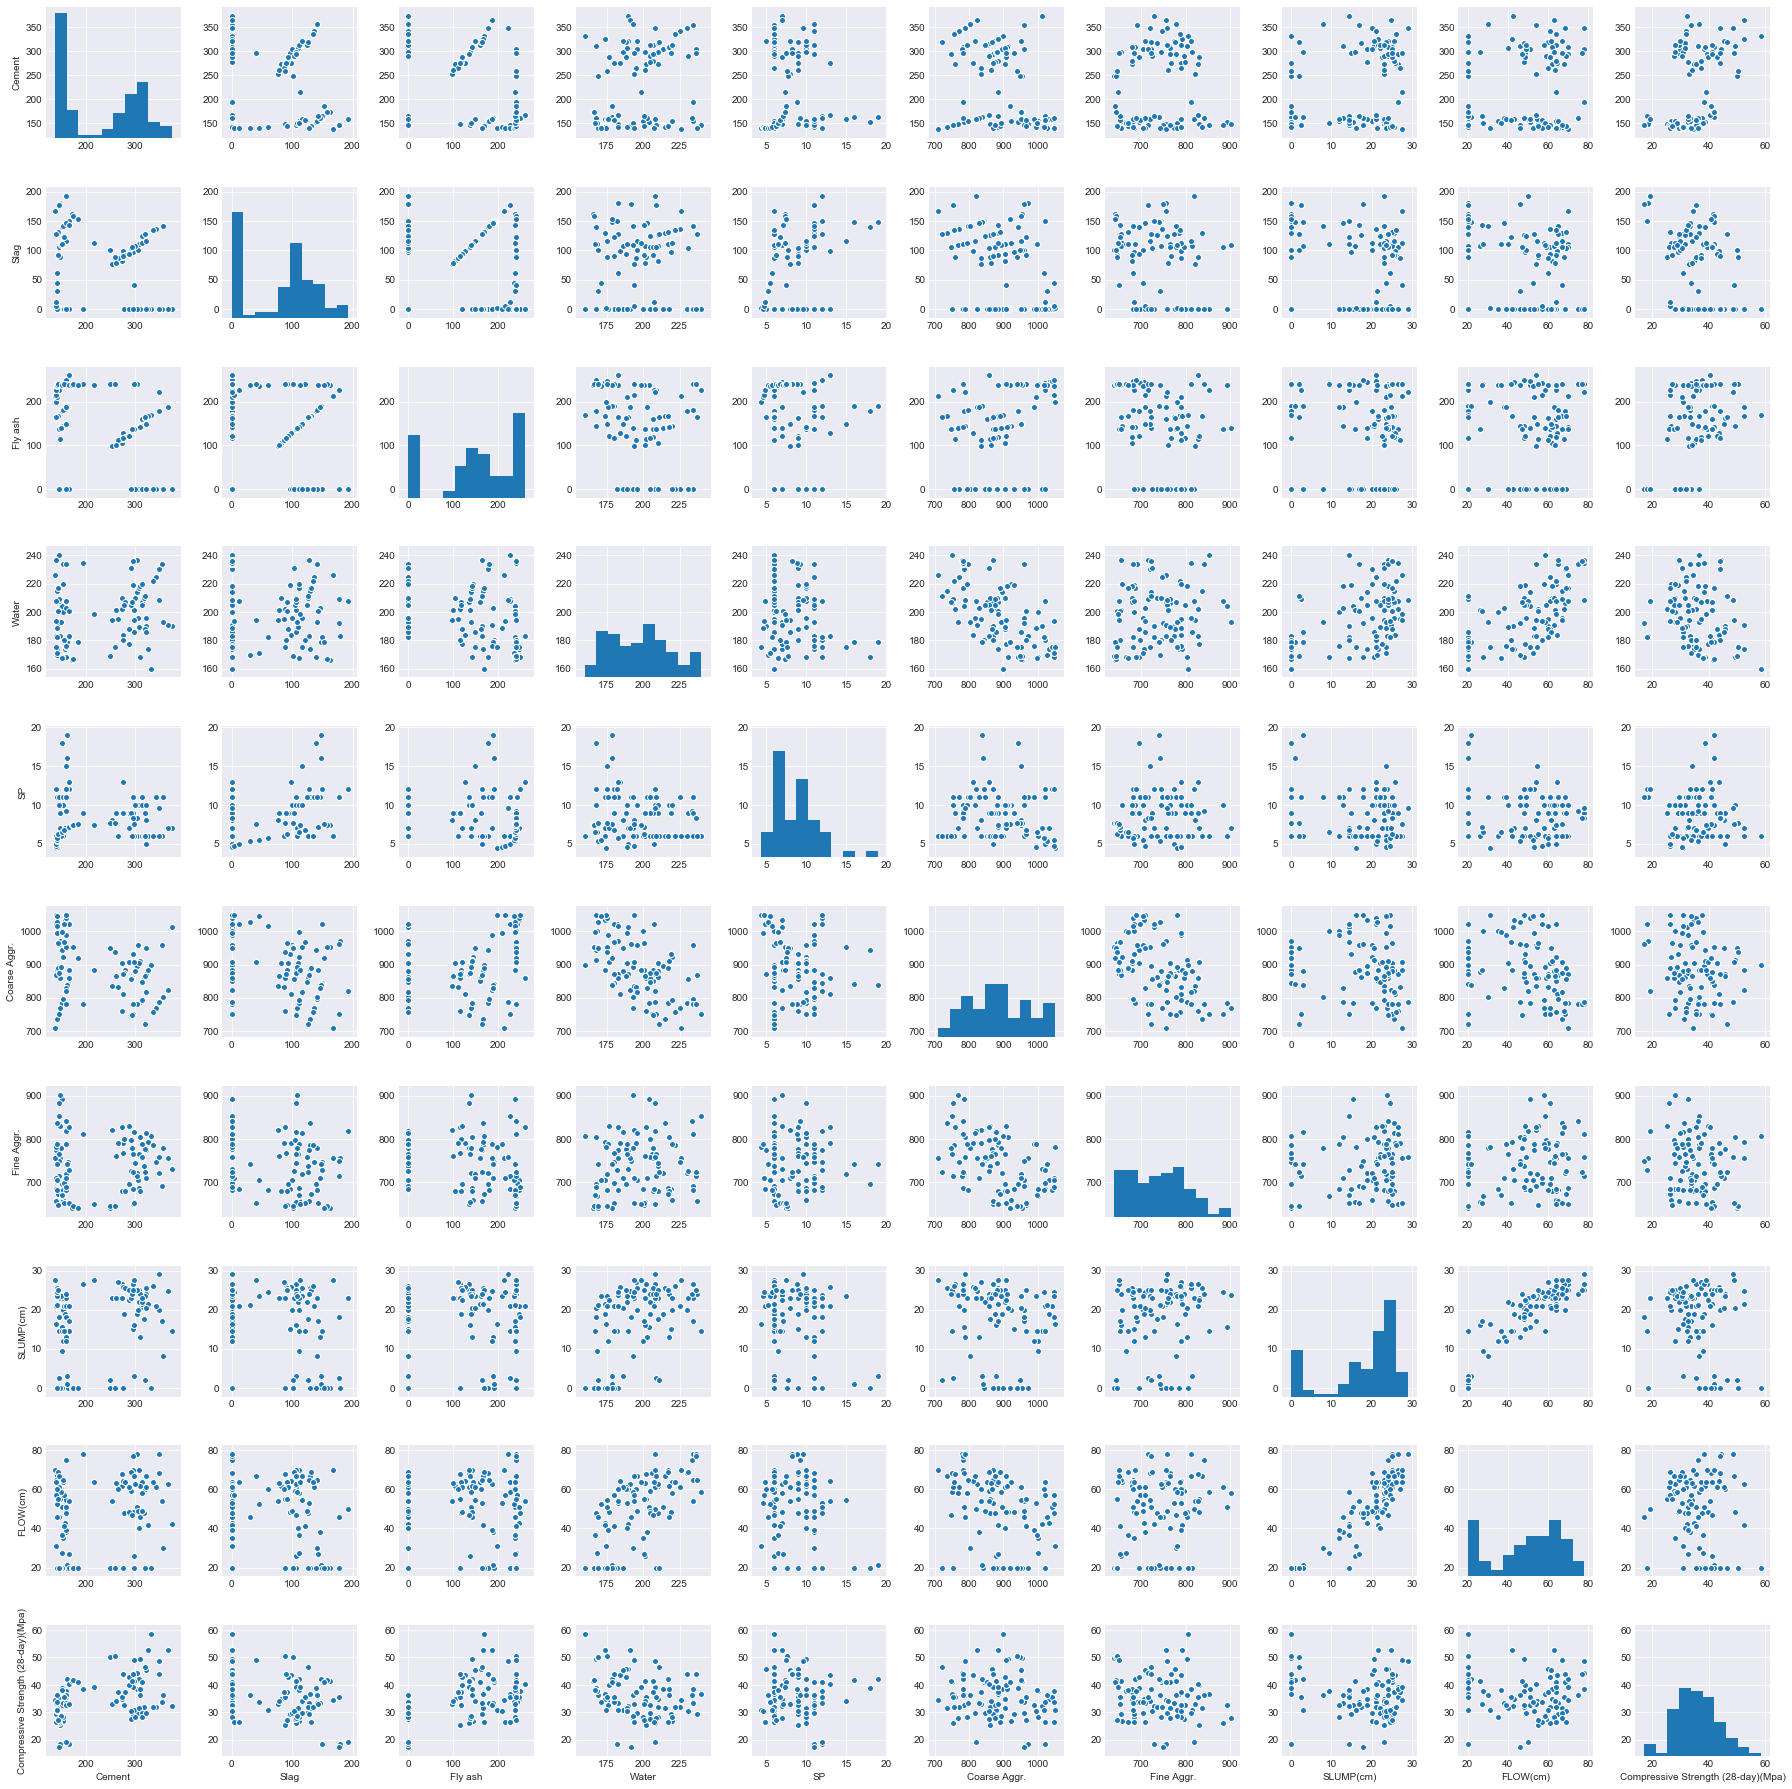

In [6]:
#Pair plot for 10 independent variables 
sns.set_style('darkgrid')
sns.pairplot(data.iloc[:,1:])
plt.show()

We have several findings here

(1) For 7 independent variables: "Water","Coarse Aggr." and "Fine Aggr." are distributed more uniformly than other indpendent variables; There is an obvious association among "Water" , "Coarse Aggr." and "Fine Aggr.". When the Water level goes up, the Coarse Aggr. level goes down; When the Water level goes up, the Fine Aggr. level also goes up; When the Coarse Aggr. level goes up, the Fine Aggr. level goes down. All of these shows the multicolinearity among the predictiors, which  means that the performance of decision trees and random forest may not be that good, as the tree models suffer from multicolinearity. 

(2) For 3 depedent variables: "Compressive Strength (28-day)(Mpa)" roughly follows normal distribution; there is a positive association between "SLUMP(cm)" and "FLOW(cm)", this is reasonable as they both describe the consistency of the concrete; there is no obvious association between "SLUMP(cm)" and "Compressive Strength (28-day)(Mpa)" or "FLOW(cm)" and "Compressive Strength (28-day)(Mpa)", which means "FLOW(cm)" or "SLUMP(cm)" may not be the indicator of "Compressive Strength (28-day)(Mpa)" solely. 

(3) "Cement" and "Water" are obvious corralated with "Compressive Strength (28-day)(Mpa)", we may include them in the model. 

###### Are there any outliers ?

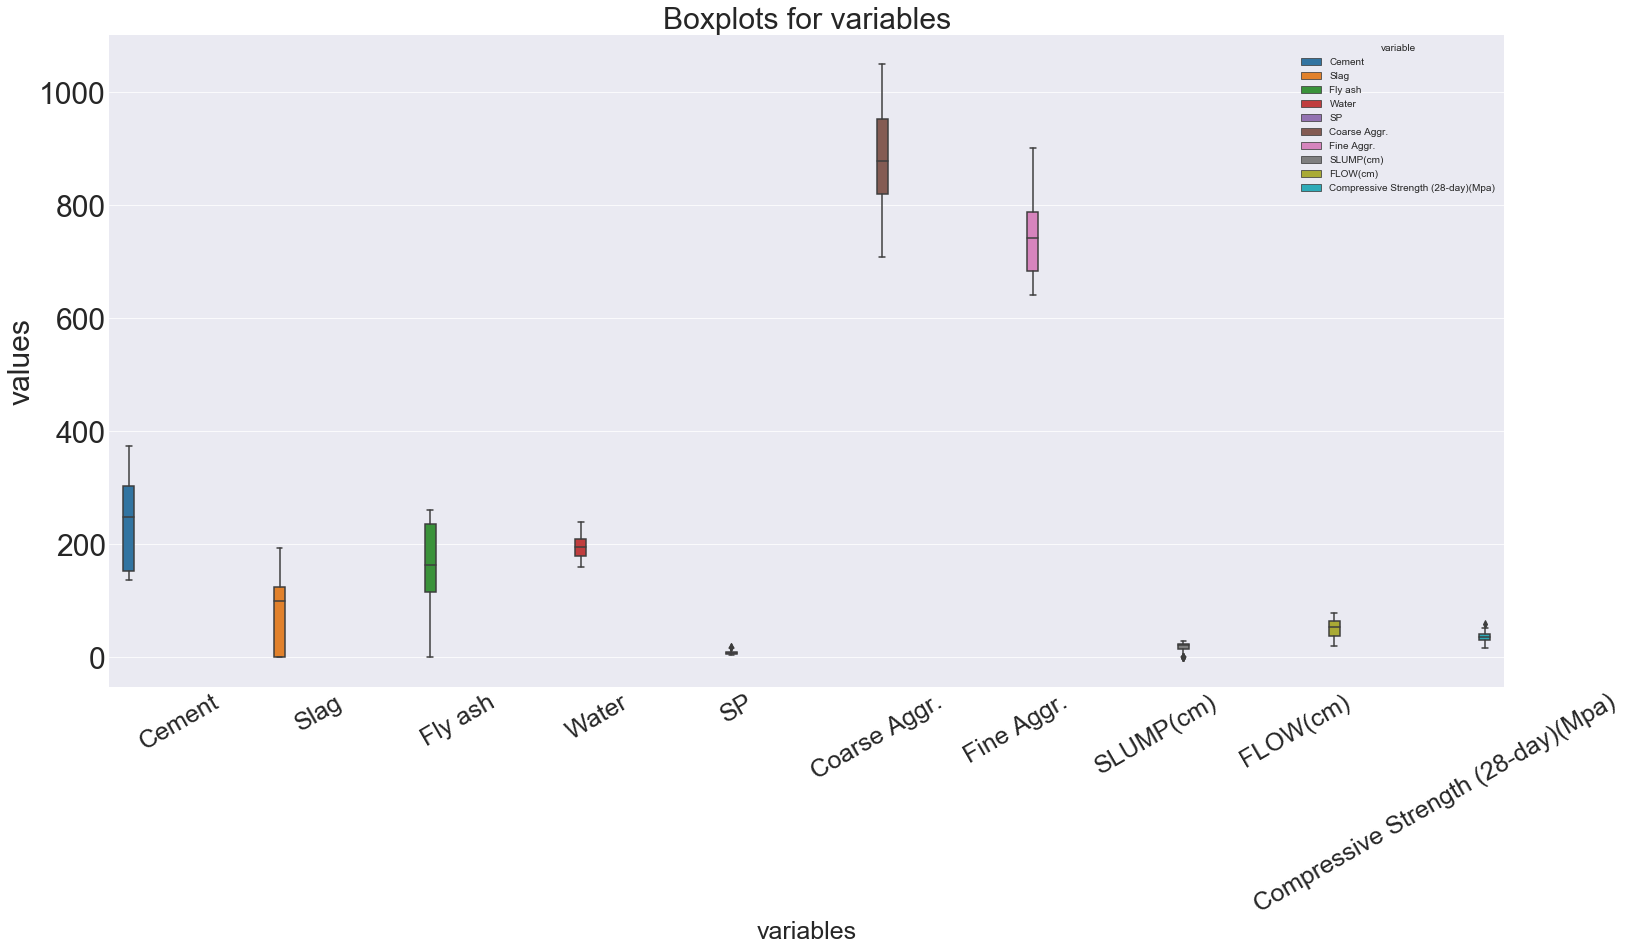

In [7]:
#Boxplot for 10 variables 
plt.figure(figsize=(25,12))
df_melted = pd.melt(data,id_vars='No')
sns.boxplot(x='variable',y='value',hue='variable',data=df_melted)
plt.title("Boxplots for variables",fontsize=30)
plt.xticks(rotation=30,fontsize=25)
plt.xlabel("variables",fontsize=25)
plt.yticks(fontsize=30)
plt.ylabel("values",fontsize=30)
plt.show()

The scales in features are very different, we may need to do feature standardization if applying other algorithms other than tree models, such as  SVM or KNN. 

Since the values of "SP", "SLUMP(cm)","FLOW(cm)" and "Compressive Strength(28-day)(Mpa)" are much smaller than other variables, let's group the boxplots into two groups, one for the variables mentioned above, one for variables other than those.

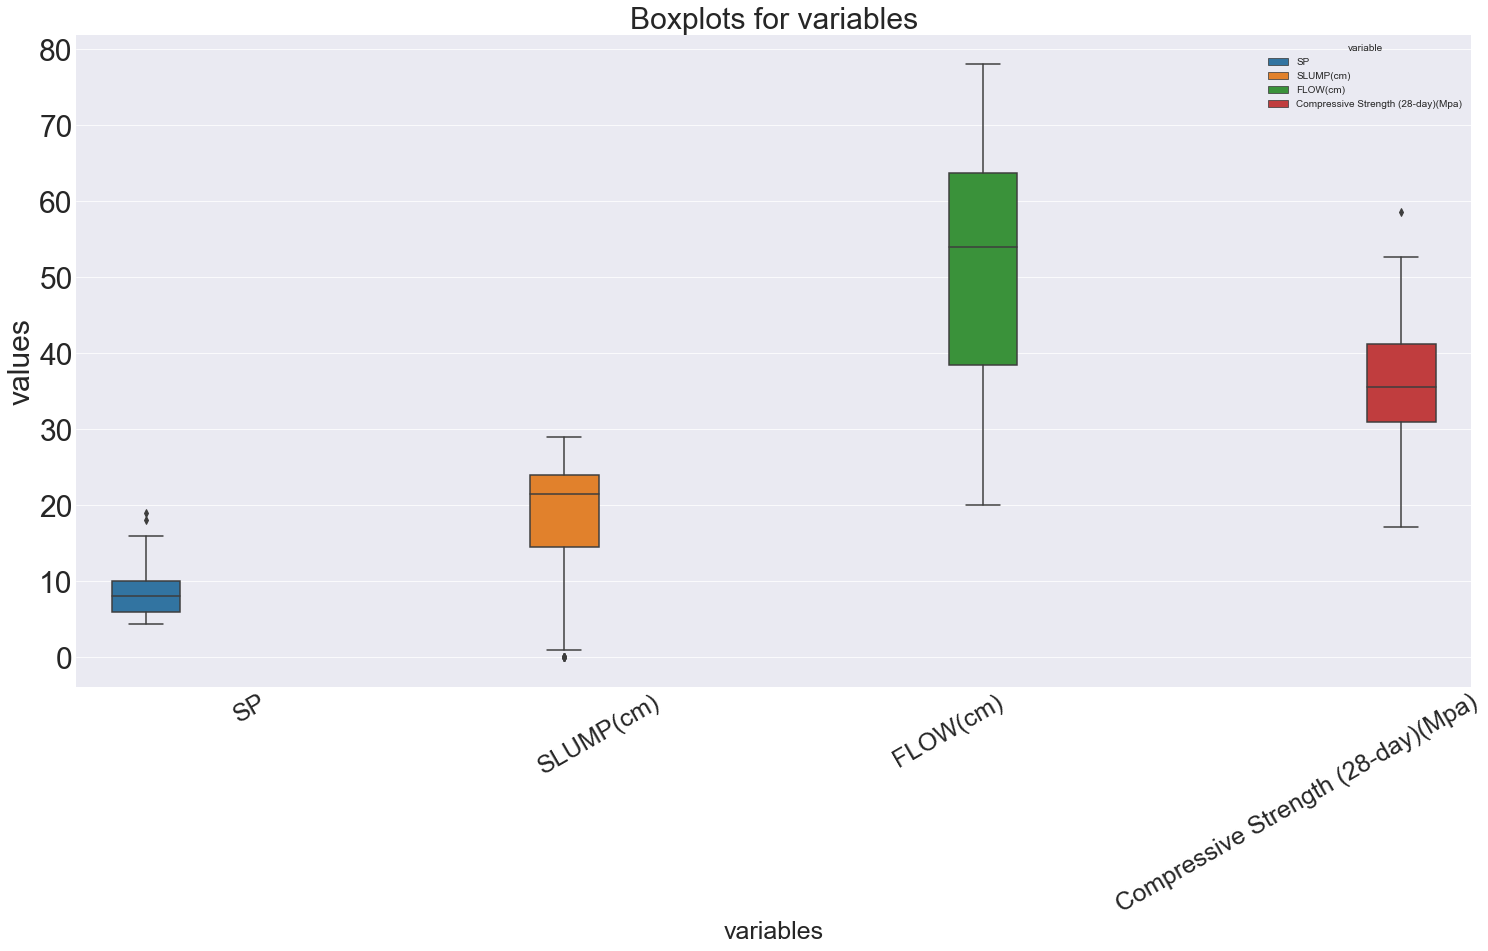

In [8]:
#Boxplots for "SP", "SLUMP(cm)","FLOW(cm)" and "Compressive Strength(28-day)(Mpa)" 
plt.figure(figsize=(25,12))
df_melted2 = pd.melt(data[["No","SP","SLUMP(cm)","FLOW(cm)","Compressive Strength (28-day)(Mpa)"]],id_vars='No')
sns.boxplot(x='variable',y='value',hue='variable',data=df_melted2)
plt.title("Boxplots for variables",fontsize=30)
plt.xticks(rotation=30,fontsize=25)
plt.xlabel("variables",fontsize=25)
plt.yticks(fontsize=30)
plt.ylabel("values",fontsize=30)
plt.show()

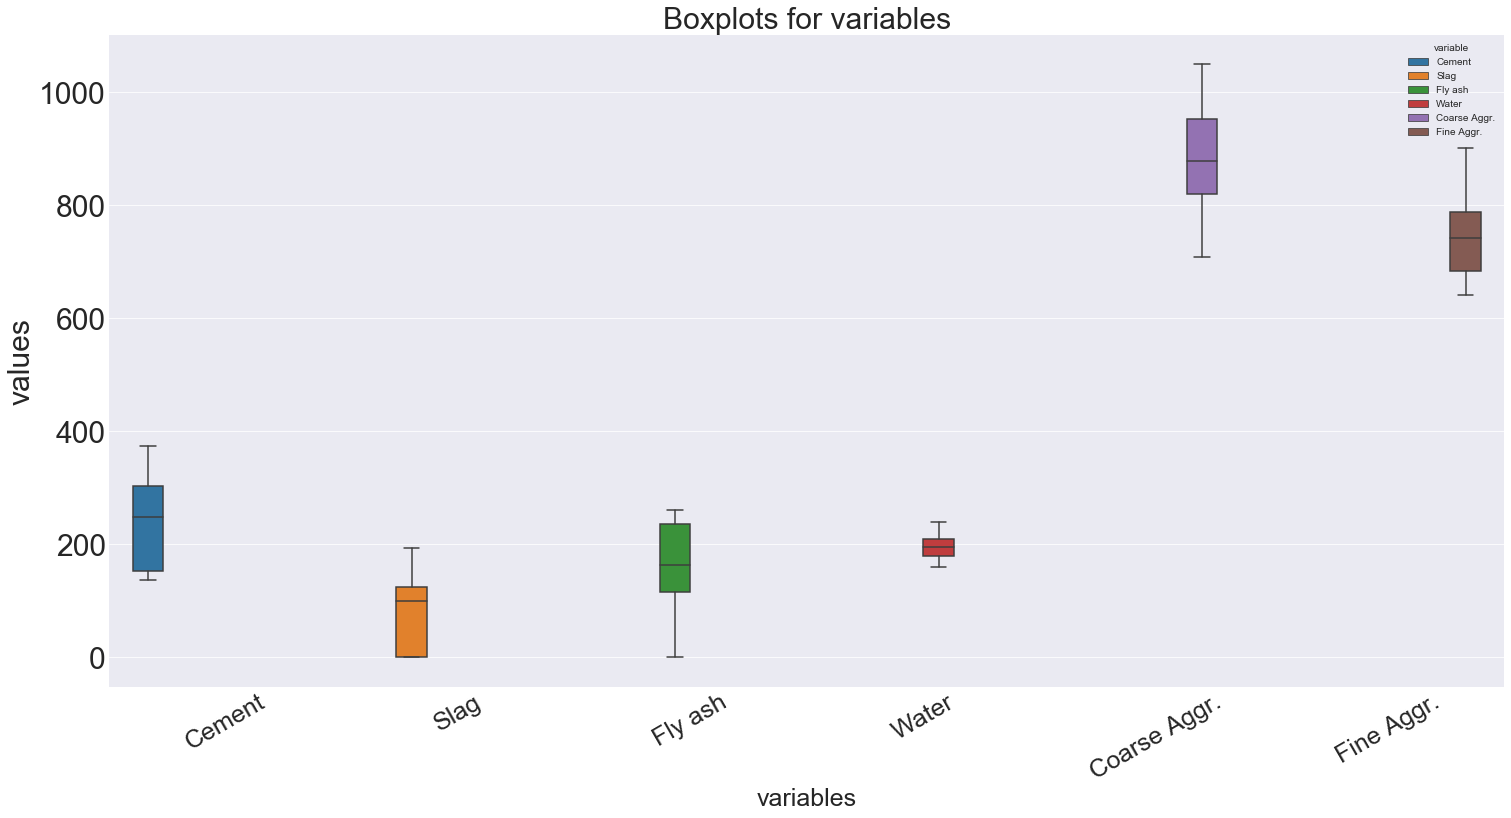

In [9]:
#Boxplots for ""Cement","Slag","Fly ash","Water","Coarse Aggr." and "Fine Aggr."
plt.figure(figsize=(25,12))
df_melted2 = pd.melt(data[["No","Cement","Slag","Fly ash","Water","Coarse Aggr.","Fine Aggr."]],id_vars='No')
sns.boxplot(x='variable',y='value',hue='variable',data=df_melted2)
plt.title("Boxplots for variables",fontsize=30)
plt.xticks(rotation=30,fontsize=25)
plt.xlabel("variables",fontsize=25)
plt.yticks(fontsize=30)
plt.ylabel("values",fontsize=30)
plt.show()

(1)"Coarse Aggr." and "Fine Aggr." are the top 2 ingredients in making most of the concrete, this comprise with the truth that "60 to 75 percent aggregate are in concrete"; While "SP(Superplasticizer)" is the least ingredient in concrete.
(2)"Water" and "SP" are the least varied variables. 
(3) The median comprehensive strength is about 35 Mpa. 
(4)There are some outliers in independent variable "SP" and dependent variable "Compressive Strength (28-day)(Mpa)", let's check how many of them. 

In [10]:
a, b = sum(data['SP'] > 17),sum(data['Compressive Strength (28-day)(Mpa)'] > 53)
print("There are %d outlliers in 'SP'" % a)
print("There are %d outlliers in 'Compressive Strength (28-day)(Mpa)'" % b)

There are 2 outlliers in 'SP'
There are 1 outlliers in 'Compressive Strength (28-day)(Mpa)'


Since there are only 3 outliers in total, I'll leave them as they contribute little to the whole dataset.

##### Summary 1:
(1) EDA process: 

Check NAs --- Distribution for different variables --- Correlations between different pairs --- Dedecting outliers; 

Finding: There is missing values in the dataset; All the variables are quantitative; "Coarse Aggr." and "Fine Aggr." are the top 2 most ingredients in the concrete and "SP(Superplasticizer)" is the least;"Water" and "SP" are the least varied variables;  There is multi-colinearity among the features("Water" , "Coarse Aggr." and "Fine Aggr."); "Cement" and "Water" are  correlated with "Compressive Strength (28-day)(Mpa)"; There are three outliers in total. 

(2) Visual representations:

Pairplot for ten variables to reveal the distribution and correlation;  Boxplot to reveal the distribution and detect the potential outliers;

Findings: The scale for different variables are very different, "SP" has much smaller values than other variables; the median compressive strength is about 35 Mpa.

(3) Influence on future analysis: 

Because of multicolinearity, the tree model may not performs better than other methods, such as SVM. We may try SVM model as future work; Only two variables shows obvious correlation with compressive strength, we need to spend some time in feature engineering; The model performance may be affected by the outliers and we need to create a more robust model in the future, such as SVM. 



### Feature Selection 

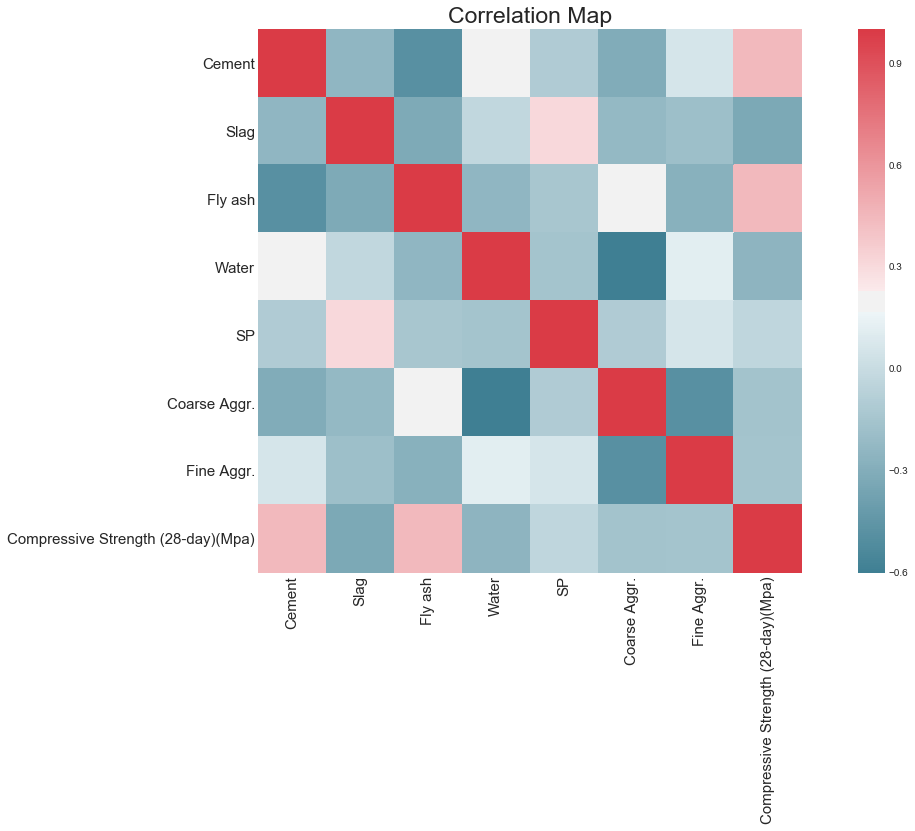

In [11]:
#Correlation Heatmap among variables
names = data.columns[1:8]
names = list(names.values)
names.append("Compressive Strength (28-day)(Mpa)")
corr = data[names].corr()
f, ax = plt.subplots(figsize=(20,10))
ax = sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
ax.set_title('Correlation Map',fontsize=23)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show() 

In [12]:
corr

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,Compressive Strength (28-day)(Mpa)
Cement,1.000000,-0.243553,-0.486535,0.221091,-0.106387,-0.309857,0.056959,0.445725
Slag,-0.243553,1.000000,-0.322619,-0.026775,0.306504,-0.223792,-0.183522,-0.331588
Fly ash,-0.486535,-0.322619,1.000000,-0.241321,-0.143508,0.172620,-0.282854,0.444393
Water,0.221091,-0.026775,-0.241321,1.000000,-0.155456,-0.602201,0.114591,-0.254235
SP,-0.106387,0.306504,-0.143508,-0.155456,1.000000,-0.104159,0.058290,-0.037871
Coarse Aggr.,-0.309857,-0.223792,0.172620,-0.602201,-0.104159,1.000000,-0.488537,-0.160684
Fine Aggr.,0.056959,-0.183522,-0.282854,0.114591,0.058290,-0.488537,1.000000,-0.154484
Compressive Strength (28-day)(Mpa),0.445725,-0.331588,0.444393,-0.254235,-0.037871,-0.160684,-0.154484,1.000000


/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


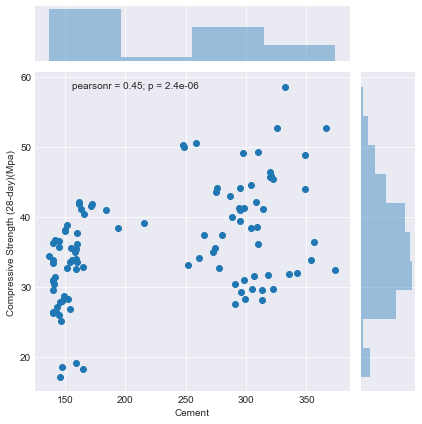

In [13]:
# Marginal plot for "Cerment" and "CS"
plt.figure(figsize=(25,12))
sns.jointplot(x=data["Cement"], y=data["Compressive Strength (28-day)(Mpa)"], kind='scatter')
plt.show()


##### Summary 2:
(1) The correlation heatmap shows that there is no variables highly correlated with CS(with absolute correlation coefficient>0.5); The top 4 variables that are correlated with CS are "Cement", "Slag","Fly ash" and "Water"; From the marginal plot, we see that for "Cement" < 200, "CS" are mostly distributed in the mid lower level(<40 Mpa); While for "Cement" > 300, "CS" are distributed in the mid upper level(>40 Mpa), which indicates positive correlation and is comfirmed by the pearson correlation=0.45. That is to say, when keeping all other variables unchanged, increasing the "Cement" level will increase the "Compressive Strength".

(2) Since "Cement" and "Fly ash" have the top 2 largest absolute pearson correlation coefficient, "Cement" and "Fly ash" are most predictive of "CS". 

Therefore, we  select "Cement" and "Fly ash" as the top two most important features.


### Modeling 

In [74]:
#Train-Test Split 
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:8],data["Compressive Strength (28-day)(Mpa)"],test_size=0.3,random_state=2019)

### Decision Tree

In [61]:
#Parameter tuning using 4-fold cross-validation 
params = {"max_depth":[2,4,5,6,7,8,9,10,12,17,30,40]}
reg = DecisionTreeRegressor(random_state=2019)
dt_cv = GridSearchCV(reg,params,cv=4)
dt_cv.fit(X_train[["Cement","Fly ash"]],y_train)
print(dt_cv.best_params_) #The best max-depth is 5 

{'max_depth': 5}


In [103]:
#Model fit 
reg1 = DecisionTreeRegressor(random_state=2019,max_depth=5)
reg1.fit(X_train[["Cement","Fly ash"]],y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=2019, splitter='best')

In [105]:
#Decision tree visualization 
export_graphviz(reg1, out_file='tree.dot', 
                feature_names = ['Cement','Fly ash'],
                class_names = 'CS',
                rounded = True, proportion = False, 
                precision = 2, filled = True)

!dot -Tpng tree.dot -o tree.png -Gdpi=600

from IPython.display import Image
Image(filename = 'tree.png')

/bin/sh: dot: command not found


In [63]:
#Model Performance
pred1 = reg1.predict(X_test[["Cement","Fly ash"]])
rmse1 = np.sqrt(mean_squared_error(y_test,pred1))
r2 = r2_score(y_test,pred1)
print("The root mean square error for decision tree is %.2f" %rmse1)
print("The R_squared is %.2f"%r2)

The root mean square error for decision tree is 4.43
The R_squared is 0.72


###### Summary 3:
(1) The decision structure is shown above; It tells us how to split the dataset at each node; For example, for node 1, we split the dataset into two groups by checking whether the "Cement" is greater than 159.5 or not; At end, we will get a number of groups based on the previous splits and can output the predicted with the mean value of the group it belongs to. 

(2) The test RMSE measures how well the model performs by measuring the difference between the predicted values and actural values in test data; RMSE = 4.43 means the average deviation of the predicted value to the actual value for "compressive strength" is 4.43.

(3) The ideal max_depth of the decision tree is 5; I use 4-fold cross validation to determine the optimal max_depth.

(4) I use R_Squared as the accuracy score for regression model, which is equal to 0.72; R_Squared = 0.72 means only 72% of variance for "compressive strength" is explained, this model performs not good.  

### Random Forest

In [90]:
#Parameter tuning 
params = {"n_estimators":[10,40,50,100,200,400,900,1000,2000]
          ,"max_depth":[4,6,8,10,20]}
reg2 = RandomForestRegressor(random_state=2019)
dt_cv2 = GridSearchCV(reg2,params,cv=4)
dt_cv2.fit(X_train,y_train)
print(dt_cv2.best_params_) #The ideal number of trees is 50 and maximum depth is 6

{'max_depth': 6, 'n_estimators': 50}


In [93]:
#Model fit 
reg3 = RandomForestRegressor(random_state=2019,n_estimators=50,max_depth=6)
reg3.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
           oob_score=False, random_state=2019, verbose=0, warm_start=False)

In [95]:
#Model Performance
pred2 = reg3.predict(X_test)
rmse2 = np.sqrt(mean_squared_error(y_test,pred2))
r22 = r2_score(y_test,pred2)
print("The root mean square error for random forest is %.2f" %rmse2)
print("The R_squared is %.2f"%r22)

The root mean square error for random forest is 3.77
The R_squared is 0.80


/Users/fangqiouyang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


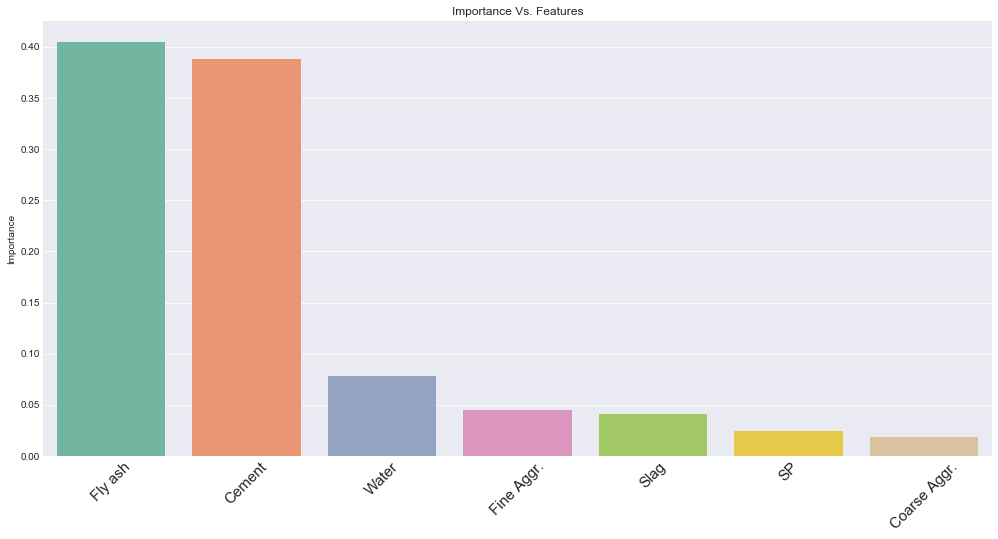

In [97]:
#Feature importance 
importance = reg3.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])
importance["Std"] = np.std([tree.feature_importances_
                            for tree in reg3.estimators_], axis=0)

x = range(importance.shape[0])[0:15]
y = importance.ix[:, 0]
y_sorted = y.sort_values(ascending=False)[0:15]
yerr = importance.ix[:, 1][0:15].loc[y_sorted.index]
fig = plt.figure(figsize=(17,8))
ax = fig.add_subplot(111)
sns.barplot(x=np.array(y_sorted.index), y=y_sorted,palette='Set2')
ax.set_xticklabels(np.array(y_sorted.index),rotation=45,fontsize=15)
ax.set_title("Importance Vs. Features")
plt.show()

###### Summary 4:
(1) The random forest includes 50 trees; I use 4-fold cross validation to tune the hyper-parameter.

(2) In the feature importances graph above,  "Fly ash","Cement" and "Water" are the top three variables with high importance; Therefore, those three variables should account for the "Compressive strength" most. 


###### Summary 5:
(1) I might try SVM and XGboost; Because SVM regression is more robust to outliers than Random Forest Regression and XGboost regression is more robust to multicolinearity than random forest regression. 

(2） The "Water" to "Cement" ratio(mostly common used), the "Water" to "binder" ratio( "binder" ="Cement"+"Fly ash"+"Slag"),"elastic modulus" of concrete, "environmental exposure condition" might be useful features.

(3) I might want to check if there is a serious multi-colinearity among the predictors by using VIF as indicators; I'll also try the PCA after adding the new features, which will not only reduce the dimension of the new data but also provides us with un-correlated predictors, in which the tree regression model may perform better. 

(4) If we can predict the "Compressive strength" of the concrete corretly, the accidents caused by the deterioration of concrete will decrease a lot; The quality of the concrete will be improved a lot under the correct supervision; The manufacturer of concrete may increase the quality of the concrete by decreasing the cost; the goverments may have less expenses on safety control. 
